<a href="https://www.kaggle.com/code/awesomeharris/ps3e15-feature-imputation-with-heat-flux-dataset?scriptVersionId=130424405" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Feature Imputation with a Heat Flux Dataset

# Getting started

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Define function to display null summary of dataframe
def null_info(df):
    num_rows = len(df)
    null_counts = df.isnull().sum()
    null_percentages = (null_counts / num_rows) * 100
    null_info = pd.DataFrame({'Null Count': null_counts, 'Null Percentage': null_percentages.round(1)})
    
    # Display null counts
    print(null_info)

# Study original dataset

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s3e15/data.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s3e15/sample_submission.csv')

In [4]:
sample_sub.head()

,id,x_e_out [-]
0,4,0.0
1,7,0.0
2,10,0.0
3,12,0.0
4,23,0.0


In [5]:
df.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [6]:
df.columns, sample_sub.columns

(Index(['id', 'author', 'geometry', 'pressure [MPa]', 'mass_flux [kg/m2-s]',
        'x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]',
        'chf_exp [MW/m2]'],
       dtype='object'),
 Index(['id', 'x_e_out [-]'], dtype='object'))

In [7]:
df.info(), print('\n'), sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   31644 non-null  int64  
 1   author               26620 non-null  object 
 2   geometry             26144 non-null  object 
 3   pressure [MPa]       27192 non-null  float64
 4   mass_flux [kg/m2-s]  26853 non-null  float64
 5   x_e_out [-]          21229 non-null  float64
 6   D_e [mm]             26156 non-null  float64
 7   D_h [mm]             27055 non-null  float64
 8   length [mm]          26885 non-null  float64
 9   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415 entries, 0 to 10414
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10415 non-null  i

(None, None, None)

In [8]:
null_info(df)

                     Null Count  Null Percentage
id                            0              0.0
author                     5024             15.9
geometry                   5500             17.4
pressure [MPa]             4452             14.1
mass_flux [kg/m2-s]        4791             15.1
x_e_out [-]               10415             32.9
D_e [mm]                   5488             17.3
D_h [mm]                   4589             14.5
length [mm]                4759             15.0
chf_exp [MW/m2]               0              0.0


In [9]:
print('Shape of dataset is',df.shape)
print('Shape of sample submission is',sample_sub.shape)

print('Any null values in dataset?',df.isnull().any().any())
print('Any null values in sample submission?',sample_sub.isnull().any().any())

Shape of dataset is (31644, 10)
Shape of sample submission is (10415, 2)
Any null values in dataset? True
Any null values in sample submission? False


In [10]:
df.columns

Index(['id', 'author', 'geometry', 'pressure [MPa]', 'mass_flux [kg/m2-s]',
       'x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]',
       'chf_exp [MW/m2]'],
      dtype='object')

# Rename columns

This step is needed because libraries like XGB cannot recognize feature names with symbols such as [ , ] or < otherwise the following error will occur:  
       *ValueError: feature_names must be string, and may not contain [, ] or <*

In [11]:
df.rename(columns={'pressure [MPa]':'pressure',
                   'mass_flux [kg/m2-s]':'mass_flux',
                   'x_e_out [-]':'x_e_out', 
                   'D_e [mm]':'D_e', 
                   'D_h [mm]':'D_h', 
                   'length [mm]':'length',
                   'chf_exp [MW/m2]':'chf_exp'}, inplace=True)
df.columns

Index(['id', 'author', 'geometry', 'pressure', 'mass_flux', 'x_e_out', 'D_e',
       'D_h', 'length', 'chf_exp'],
      dtype='object')

# Create train and test dataset

In [12]:
# Separate Non Null and Null x_e_out rows from the dataset

data = df.copy()
train = data[data['x_e_out'].notnull()].drop(columns='id', axis=1)
test = data[data['x_e_out'].isnull()].drop(columns='x_e_out',axis=1)
test_id = test['id']

In [13]:
print('Shape of train dataset is',train.shape)
print('Shape of test dataset is',test.shape)

Shape of train dataset is (21229, 9)
Shape of test dataset is (10415, 9)


In [14]:
print('Train set:'), train.info(), print('\n'), print('Test set:'), test.info()

Train set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21229 entries, 0 to 31643
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   author     17826 non-null  object 
 1   geometry   17516 non-null  object 
 2   pressure   18243 non-null  float64
 3   mass_flux  18002 non-null  float64
 4   x_e_out    21229 non-null  float64
 5   D_e        17588 non-null  float64
 6   D_h        18102 non-null  float64
 7   length     18072 non-null  float64
 8   chf_exp    21229 non-null  float64
dtypes: float64(7), object(2)
memory usage: 1.6+ MB


Test set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10415 entries, 4 to 31642
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10415 non-null  int64  
 1   author     8794 non-null   object 
 2   geometry   8628 non-null   object 
 3   pressure   8949 non-null   float64
 4   mass_flux  8851 non-null

(None, None, None, None, None)

In [15]:
print('Train set:'), null_info(train), print('\n'), print('Test set:'), null_info(test)

Train set:
           Null Count  Null Percentage
author           3403             16.0
geometry         3713             17.5
pressure         2986             14.1
mass_flux        3227             15.2
x_e_out             0              0.0
D_e              3641             17.2
D_h              3127             14.7
length           3157             14.9
chf_exp             0              0.0


Test set:
           Null Count  Null Percentage
id                  0              0.0
author           1621             15.6
geometry         1787             17.2
pressure         1466             14.1
mass_flux        1564             15.0
D_e              1847             17.7
D_h              1462             14.0
length           1602             15.4
chf_exp             0              0.0


(None, None, None, None, None)

# Dealing with NA data in other columns

### Drop all rows with NA

In [16]:
train1 = train.dropna(axis=0).reset_index().drop('index',axis=1)

In [17]:
test1 = test.dropna(axis=0)
test2 = test[~test['id'].isin(test1['id'])]

In [18]:
test1.shape,test2.shape

((3160, 9), (7255, 9))

In [19]:
print('Shape of train dataset before dropping NA is',train.shape)
print('Shape of train dataset after dropping NA is',train1.shape)
print('  Number of rows reduced is', train.shape[0]-train1.shape[0],)
print('Shape of test dataset before dropping NA is',test.shape)
print('Shape of test dataset after dropping NA is',test1.shape)
print('  Number of rows reduced is', test.shape[0]-test1.shape[0])

Shape of train dataset before dropping NA is (21229, 9)
Shape of train dataset after dropping NA is (6538, 9)
  Number of rows reduced is 14691
Shape of test dataset before dropping NA is (10415, 9)
Shape of test dataset after dropping NA is (3160, 9)
  Number of rows reduced is 7255


In [20]:
train1.head()

,author,geometry,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
0,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
1,Peskov,tube,12.00,1617.0,0.1228,10.0,10.0,520.0,2.2
2,Thompson,tube,12.07,3255.0,0.0406,1.9,1.9,152.0,2.9
3,Thompson,tube,10.41,2563.0,0.1092,4.6,4.6,229.0,6.8
4,Janssen,annulus,9.68,5615.0,0.0196,12.7,38.1,914.0,2.9


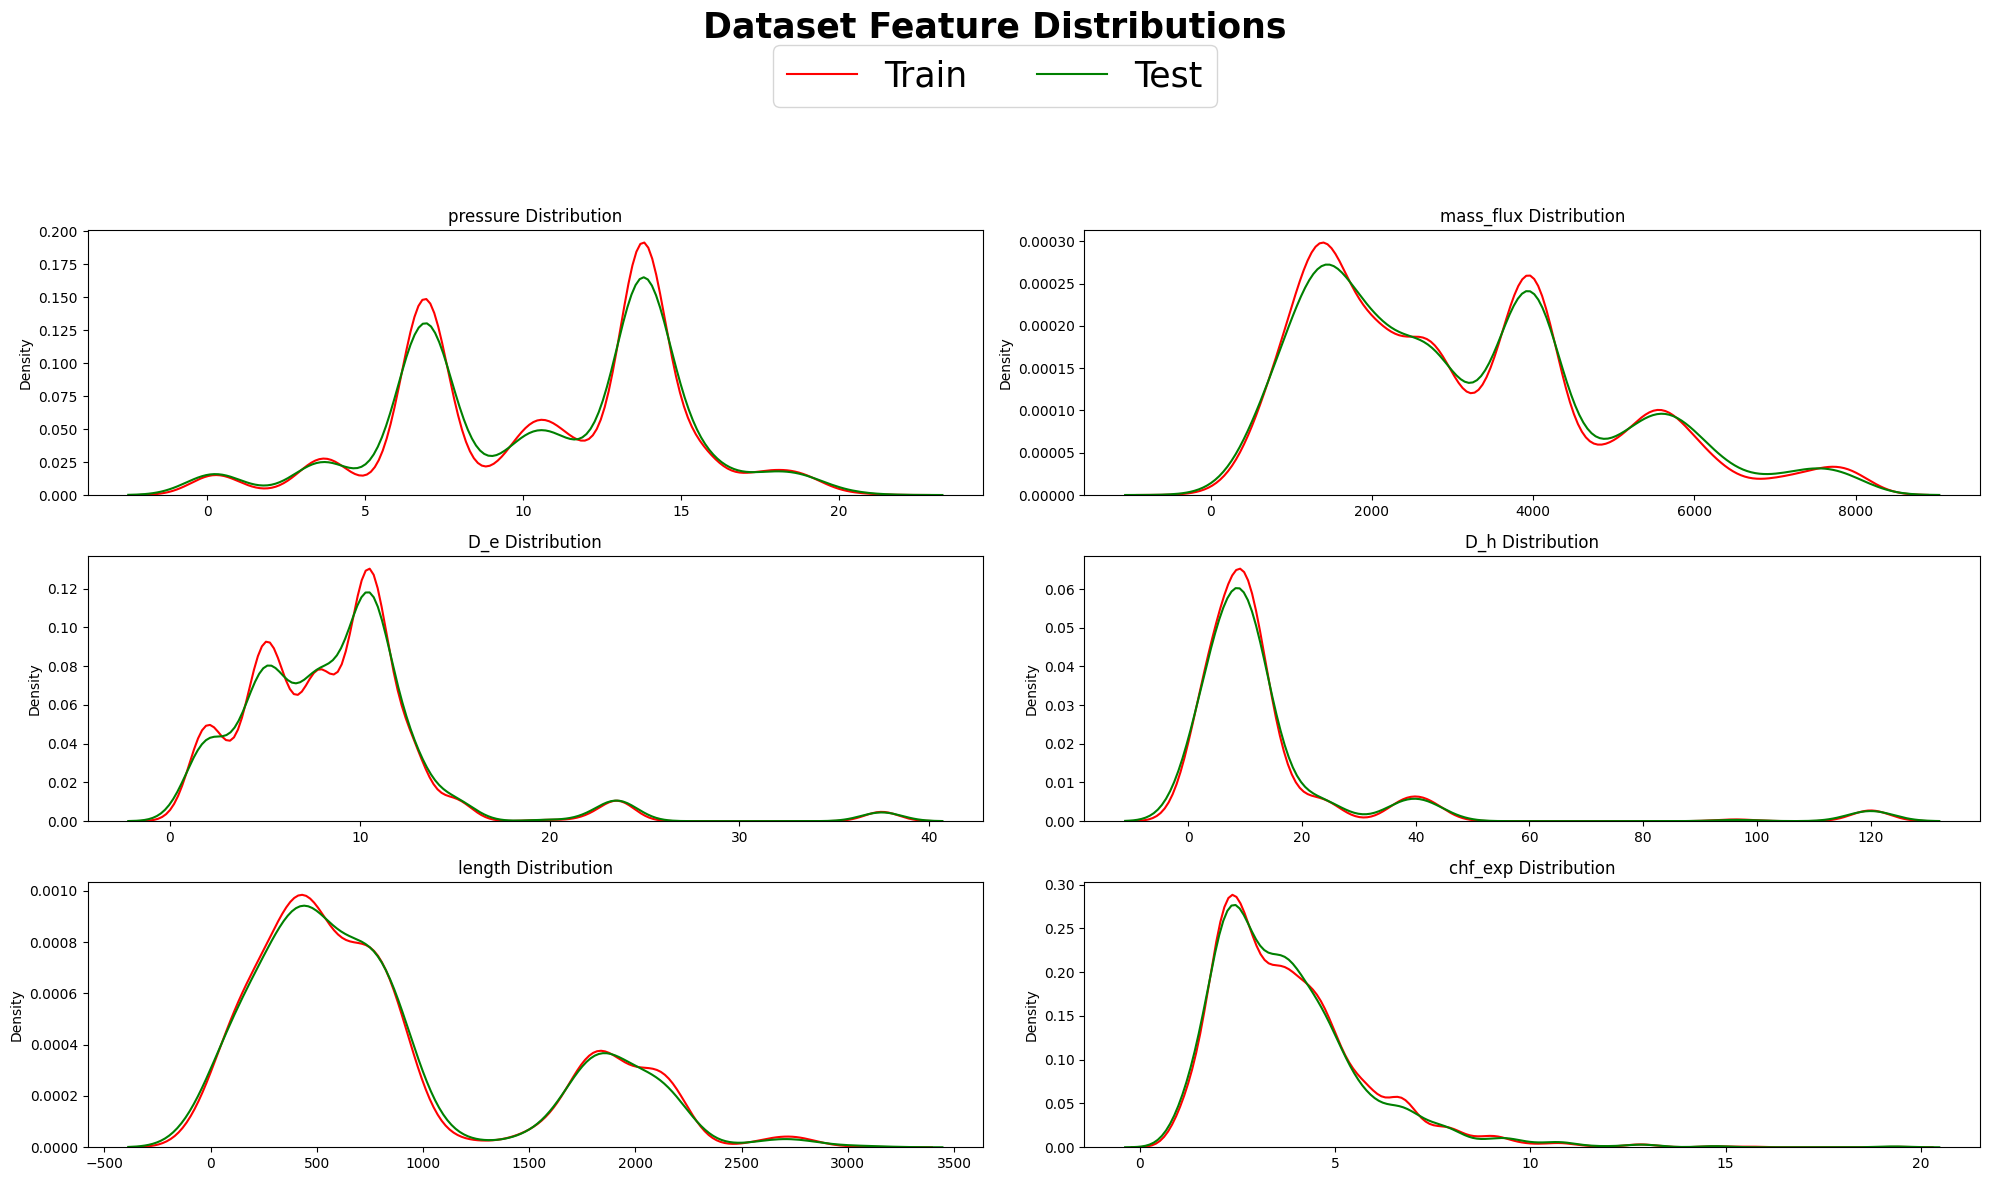

In [21]:
# kudos to @jcaliz
import math
features = ['pressure', 'mass_flux',
       'D_e', 'D_h', 'length',
       'chf_exp']
n_bins = 100
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 2
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train1[column], label='Train',
        ax=ax[i], color='r'
    )
    
    sns.kdeplot(
        test1[column], label='Test',
        ax=ax[i], color='g'
    )
    '''
    sns.kdeplot(
        data_origin[column], label='Origin',
        ax=ax[i], color='b'
    )
    '''
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.965), fontsize=25, ncol=3)
plt.tight_layout()

# Correlation Heatmap

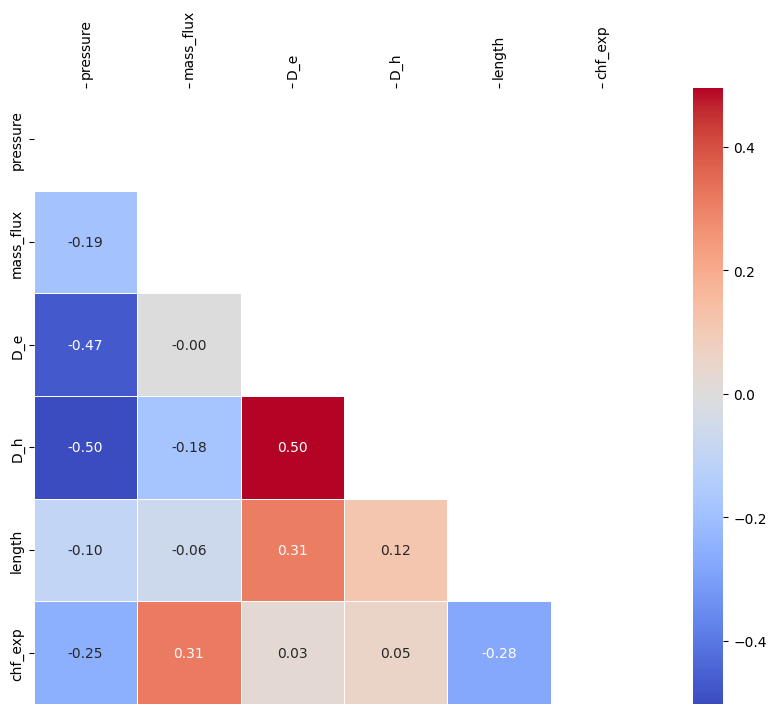

In [22]:
df_corr = train.drop('x_e_out',axis=1)

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Create a mask to hide the upper triangular portion
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the figure size
plt.figure(figsize=(10, 8))

# Plot the correlation heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', \
            fmt=".2f", linewidths=0.5, annot_kws={"size": 10})

# Adjust the font size of the annotations
plt.tick_params(axis='both', which='both', labelsize=10)

# Change x-axis legend position to top
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=90)

# Display the heatmap
plt.show()

# One-hot encode categorical features

In [23]:
train2 = train1.copy()
dummyforauthor = pd.get_dummies(train2['author'])
dummyforgeometry = pd.get_dummies(train2['geometry'])
train2 = pd.concat([train2, dummyforauthor, dummyforgeometry], axis=1)\
                    .drop(columns=['author','geometry'],axis=1)


# Build model

In [24]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

X = train2.drop(columns='x_e_out',axis=1)
y = train1['x_e_out']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
from sklearn.metrics import mean_squared_error

xgb = XGBRegressor(random_state=0).fit(X_train, y_train)
y_pred = xgb.predict(X_valid)
rmse = mean_squared_error(y_pred, y_valid)
print("Root Mean Squared Error:" , rmse)

Root Mean Squared Error: 0.006060708849000429


Notes:  
- Train test split is performed on train dataset to validate the model. 
- The resulting RMSE value is really low. It means that the above model can predict the target quite well given that there is no missing data in other features. 
- What about the portion of test dataset with missing data in other features which makes up most of the test dataset?
- The exact figure for above is 7255 / 10415 = 69.7%! 
- It is assumed that the above model can only predict well for 29.3% of the dataset with complete data in other features.

# Prepare test dataset

Like before, the test dataset will be separated into two subsets, those without NA in other features and those with NA in other features.

The idea is to treat these two subsets separately to maximize the prediction accuracy for the subset with complete feature data, and try to impute the subset with NA in other columns and predict them separately.

In [25]:
test_all = test.copy()
test_dropna = test1.copy()
test_onlyna = test2.copy()

# One-hot encode subset with complete data
dummyforauthor = pd.get_dummies(test_dropna['author'])
dummyforgeometry = pd.get_dummies(test_dropna['geometry'])
test_dropna = pd.concat([test_dropna, dummyforauthor, dummyforgeometry], axis=1)\
                    .drop(columns=['author','geometry'],axis=1)

# Impute categorical data randomly
authorlist = pd.Series(df['author'].unique())
geometrylist = pd.Series(df['geometry'].unique())

np.random.seed(42)
test_onlyna['author'] = test_onlyna['author'].fillna(pd.Series(np.random.choice(authorlist, size=len(test_onlyna), replace=True)))
test_onlyna['geometry'] = test_onlyna['geometry'].fillna(pd.Series(np.random.choice(geometrylist, size=len(test_onlyna), replace=True)))

# One-hot encode subset with missing data
dummyforauthor = pd.get_dummies(test_onlyna['author'])
dummyforgeometry = pd.get_dummies(test_onlyna['geometry'])
test_onlyna = pd.concat([test_onlyna, dummyforauthor, dummyforgeometry], axis=1)\
                    .drop(columns=['author','geometry'],axis=1)

# Impute numerical data using mean strategy
from sklearn.impute import SimpleImputer

cols = ['pressure', 'mass_flux', 'D_e', 'D_h', 'length', 'chf_exp']
imputer = SimpleImputer(strategy='mean')
imputer.fit(test_onlyna[cols])
test_onlyna[cols] = imputer.transform(test_onlyna[cols])

In [26]:
# Combine the two subsets for prediction

test_final = pd.concat([test_dropna, test_onlyna],axis=0).sort_values(by='id', ascending=True).drop('id',axis=1)
test_final.head()

,pressure,mass_flux,D_e,D_h,length,chf_exp,Beus,Inasaka,Janssen,Kossolapov,Mortimore,Peskov,Richenderfer,Thompson,Weatherhead,Williams,annulus,plate,tube
4,13.790000,686.000000,11.100000,11.1,457.0,2.8,0,0,1,0,0,0,0,0,0,0,0,0,1
7,18.000000,750.000000,10.000000,10.0,1650.0,2.2,0,0,0,0,0,1,0,0,0,0,0,0,1
10,10.703797,3045.603409,1.900000,1.9,152.0,3.2,0,0,0,0,0,0,0,1,0,0,0,0,1
12,6.890000,7500.000000,8.665902,12.8,1930.0,4.8,0,0,0,0,0,0,0,1,0,0,1,0,0
23,15.510000,1355.000000,5.600000,15.2,2134.0,2.1,1,0,0,0,0,0,0,0,0,0,1,0,0


# Final Prediction

In [27]:
X_test = test_final
y_final = xgb.predict(X_test)
output = pd.DataFrame({'id': test_id, 'x_e_out [-]': y_final})
print(output.head())

    id  x_e_out [-]
4    4     0.038993
7    7    -0.081213
10  10    -0.053608
12  12     0.036644
23  23     0.089542


In [28]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
